In [1711]:
# Google Drive マウント
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/卒業研究/DeadReckoning_ExperimentalData/ML
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/卒業研究/DeadReckoning_ExperimentalData/ML
data/                logs/           model/        Untitled0.ipynb
DeadReckoning.ipynb  makedata.ipynb  others/
graph/               ML_angle.ipynb  __pycache__/
loaddata.ipynb       ML.ipynb        scripts/


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

plt.style.use('ggplot')

In [0]:
# データ読み込み関数
def load_data(filename):
    data = np.loadtxt(filename, delimiter=',', skiprows=1,
                      unpack=False, dtype=str)
    time = data[:, 0].astype('f8')
    speed = data[:, 1].astype('f8')
    speed = speed[:, np.newaxis]
    acc = data[:, 2:2+3*50].astype('f8')
    return time, acc, speed

In [0]:
# 学習データとテストデータに分割
def splitData(time, x, t, ratio=0.9):
    border = int(len(x) * ratio)
    return (time[:border], x[:border], t[:border]), (time[border:], x[border:], t[border:])

In [1715]:
# データの読み込み
time, acc, speed = load_data('data/191121_1625/ML.csv')
print(len(time))

1860


In [0]:
SPEED_MAX = 2.5
speed /= SPEED_MAX

# シャッフル
zipped = list(zip(time, acc, speed))
np.random.shuffle(zipped)
time, acc, speed = zip(*zipped)
time = np.asarray(time)
acc = np.asarray(acc)
speed = np.asarray(speed)

# 分割
(time_train, x_train, t_train), (time_test, x_test, t_test) = splitData(time, acc, speed)

In [0]:
# ハイパーパラメータ
activation = 'relu'
activation_output = 'sigmoid'
learning_rate = 0.001
optimizer = 'adam'
loss = 'mse'

In [1718]:
import keras.backend as K
K.clear_session()

# モデル生成
model = keras.models.Sequential([
    layers.Input(shape=(150,)),
    layers.Dropout(0.2),
    layers.Dense(100, activation=activation),
    layers.Dense( 50, activation=activation),
    layers.Dense( 25, activation=activation),
    layers.Dense( 12, activation=activation),
    # layers.Dense(  6, activation=activation),
    layers.Dense(  1, activation=activation_output)
])

adam = keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=adam, loss=loss, metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 150)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               15100     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_3 (Dense)              (None, 12)                312       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 13        
Total params: 21,750
Trainable params: 21,750
Non-trainable params: 0
____________________________________________________

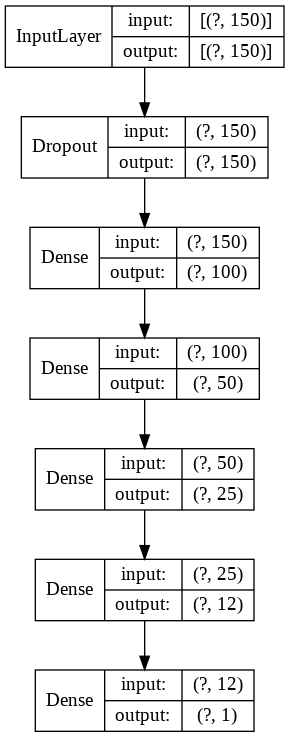

In [1719]:
# モデルの可視化
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='graph/model.png',
           show_shapes=True, show_layer_names=False)

In [1720]:
# モデルの訓練
result = model.fit(x_train, t_train, epochs=100,
                   validation_data=(x_test, t_test))

Train on 1674 samples, validate on 186 samples
Epoch 1/100
1674/1674 [==============================] - 0s 186us/sample - loss: 0.0287 - mean_absolute_error: 0.1361 - val_loss: 0.0169 - val_mean_absolute_error: 0.1021
Epoch 2/100
1674/1674 [==============================] - 0s 86us/sample - loss: 0.0136 - mean_absolute_error: 0.0910 - val_loss: 0.0070 - val_mean_absolute_error: 0.0647
Epoch 3/100
1674/1674 [==============================] - 0s 78us/sample - loss: 0.0107 - mean_absolute_error: 0.0803 - val_loss: 0.0085 - val_mean_absolute_error: 0.0734
Epoch 4/100
1674/1674 [==============================] - 0s 81us/sample - loss: 0.0085 - mean_absolute_error: 0.0711 - val_loss: 0.0055 - val_mean_absolute_error: 0.0577
Epoch 5/100
1674/1674 [==============================] - 0s 78us/sample - loss: 0.0084 - mean_absolute_error: 0.0697 - val_loss: 0.0045 - val_mean_absolute_error: 0.0512
Epoch 6/100
1674/1674 [==============================] - 0s 80us/sample - loss: 0.0071 - mean_absolute

In [0]:
# モデルの保存
# model.save('my_model.h5')

In [0]:
# テスト
y_train = model.predict(x_train)
t_train *= SPEED_MAX
y_train *= SPEED_MAX

y_test = model.predict(x_test)
t_test *= SPEED_MAX
y_test *= SPEED_MAX

In [1723]:
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(t_train, y_train) * 100)
print(mean_absolute_error(t_test, y_test) * 100)

5.886683888860649
7.211638374203649


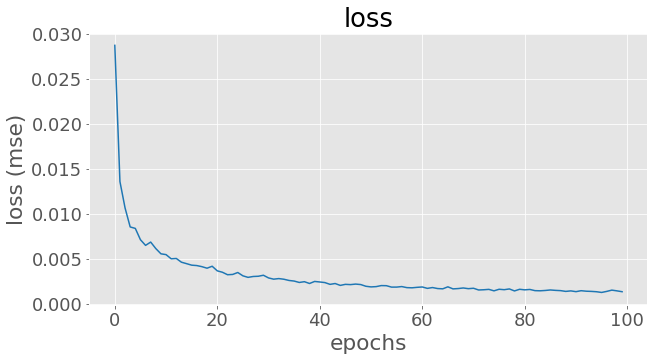

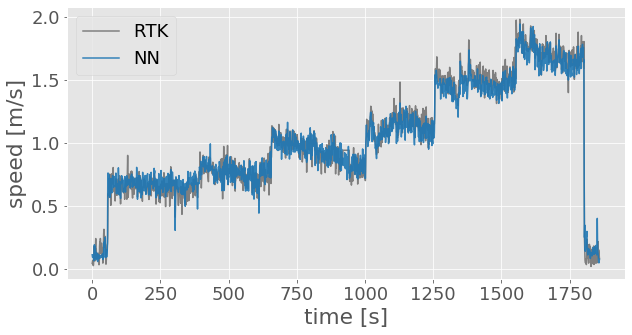

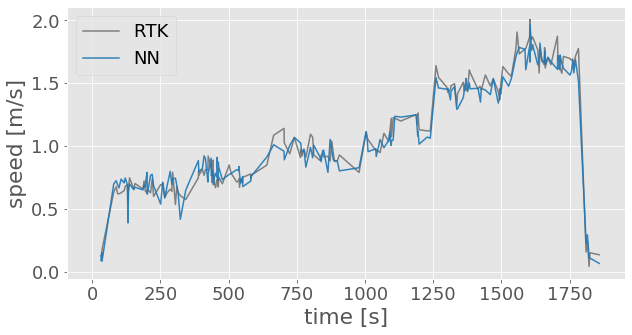

In [1724]:
from sklearn.metrics import mean_absolute_error

# グラフ表示
plt.rcParams['font.size'] = 18

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(111)
ax1.set_title('loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss (mse)')
ax1.plot(result.history['loss'], color='tab:blue', label="training")


fig = plt.figure(figsize=(10, 5))
ax2 = fig.add_subplot(111)
ax2.set_xlabel('time [s]')
ax2.set_ylabel('speed [m/s]')

zipped = zip(time_train, t_train, y_train)
zipped = sorted(zipped)
time_train, t_train, y_train = zip(*zipped)

ax2.plot(time_train, t_train, color='tab:gray', label='RTK')
ax2.plot(time_train, y_train, color='tab:blue', label='NN', alpha=0.9)
ax2.legend(loc='upper left')


fig = plt.figure(figsize=(10, 5))
ax3 = fig.add_subplot(111, sharex=ax2)
ax3.set_xlabel('time [s]')
ax3.set_ylabel('speed [m/s]')

zipped = zip(time_test, t_test, y_test)
zipped = sorted(zipped)
time_test, t_test, y_test, = zip(*zipped)

ax3.plot(time_test, t_test, color='tab:gray', label='RTK')
ax3.plot(time_test, y_test, color='tab:blue', label='NN', alpha=0.9)
ax3.legend(loc='upper left')

fig.align_labels()
fig.subplots_adjust(hspace=0.8)
# fig.savefig('graph/graph.png')

In [0]:
time_test2, x_test2, t_test2 = load_data('data/191204_1956/ML.csv')

# テストデータでテスト
y_test2 = model.predict(x_test2)
y_test2 *= SPEED_MAX

0.12679421732258894

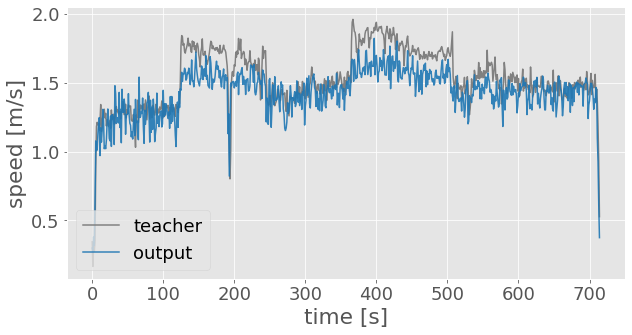

In [1726]:
# グラフ表示
plt.figure(figsize=(10, 5))
plt.xlabel('time [s]')
plt.ylabel('speed [m/s]')
plt.plot(time_test2, t_test2, color='gray', label='teacher')
plt.plot(time_test2, y_test2, label='output', alpha=0.9, color='tab:blue')
plt.legend(loc='lower left')

mean_absolute_error(t_test2, y_test2)